In [12]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import random
import sys
import multiprocessing
import scipy
import pickle, os, glob, re
from joblib import Parallel, delayed
import threading
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader
from tf_gmm_em import *

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')
    
train_df_int = train_df
for i in train_tissues:
    train_df_int[i] = data_loader.local_impute(train_df[i].copy())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in interpolated 0


In [13]:
# Verify that we get similar likelihoods with e step.

# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

with tf.Session() as sess:
    mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.66439636  0.79073654  0.86246146  0.78010372  0.66644286]
 [ 0.296676    0.14671455  0.12862767  0.06847246  0.29108036]
 [ 0.03892765  0.06254891  0.00891087  0.15142382  0.04247678]]
log likelihoods    [[ 0.66439636  0.79073654  0.86246146  0.78010372  0.66644286]
 [ 0.296676    0.14671455  0.12862767  0.06847246  0.29108036]
 [ 0.03892765  0.06254891  0.00891087  0.15142382  0.04247678]]
K=0 rmse=4.413049240337539e-16
K=1 rmse=4.535723058779543e-16
K=2 rmse=6.045704196024149e-17


means
[[ 20.17616371  20.10495483]
 [  0.53687504   0.23774479]
 [ 10.42055163  10.07351857]]
cov
[[  1.46528671   1.06578162]
 [ 11.56134039   0.85248074]
 [  1.71172277  12.49839639]]
cluster priors
[ 0.33333333  0.34278281  0.32388386]


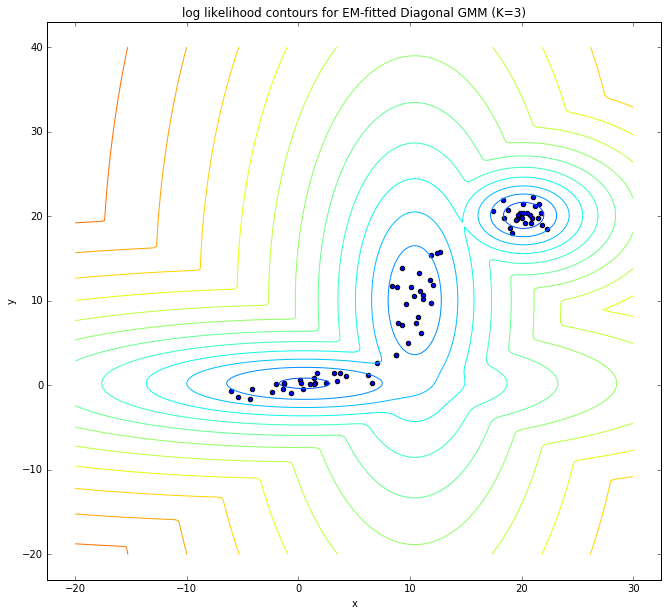

In [3]:
# Check that EM is working on small 2D example

n_samples = 25
np.random.seed(0)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return np.dot(rs, shear.T) + shift
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[0., 3.5], [-0.7, .7]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3])
rx = np.random.choice(range(len(X)), 3, replace=False)

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
_, m, s, a = fit_em(X, X[rx], 100, EPS)
x = np.linspace(-20.0, 30.0, 200)
y = np.linspace(-20.0, 40.0, 200)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T
with tf.Session() as sess:
    ll = sess.run(-estep(pts, m, s, a)[0])
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
plt.figure(figsize=(11, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
#plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.title('log likelihood contours for EM-fitted Diagonal GMM (K=3)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
# Make this into a nice image.
ys = [-10, 0, 2.5, 10, 20]
pts = np.arange(-20, 30, 0.1, dtype='float64').reshape(-1, 1)
ys = np.array(ys, dtype='float64').reshape(-1, 1)
# Reverse m, s, a, since we know 'y'
mr, sr = (x[:, ::-1] for x in (m, s))
plotmm, plotsm, plotlgams = marginal_posterior(ys, mr, sr, a)

mle_ys = np.arange(-20, 40, 0.1, dtype='float64').reshape(-1, 1)
mm, sm, lgams = marginal_posterior(mle_ys, mr, sr, a)
ams = np.exp(lgams)
argmax_xs = [argmax_exp(mm, sm, am) for am in lgams]

mle_xs = [None] * len(ams)

def globall(): return glob.glob('data/3-cluster-mle-[0-9]*-[0-9]*.p')

if len(globall()) == 0:
    print('Missing cached posterior MLE predictions, re-generating.')
    with open('data/3-cluster-posterior.p', 'wb') as w:
        pickle.dump((mm, sm, ams), w)
    print(len(mle_ys))
    ! ./xargs-compute-gd-mle.sh data/3-cluster-posterior.p {len(mle_ys)} {nproc // 2} 3-cluster | grep 'Warning'
    print('Done generating')

for f in globall():
    with open(f, 'rb') as r:
        xs = pickle.load(r)
    lo, hi = (int(s[1:]) for s in re.findall(r'-\d+', f))
    mle_xs[lo:hi] = xs
    
print(len(globall()))

23


[[-10. ]
 [  0. ]
 [  2.5]
 [ 10. ]
 [ 20. ]]


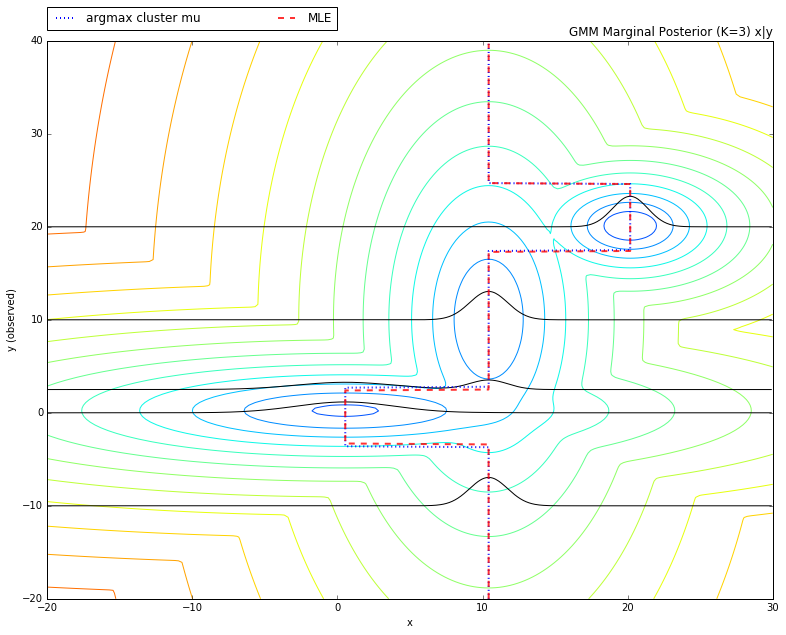

In [5]:
print(ys)
plt.figure(figsize=(13, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
with tf.Session() as sess:
    for i, y in enumerate(ys.reshape(-1)):
        lla = sess.run(estep(pts, plotmm, plotsm, np.exp(plotlgams[i]))[0]).reshape(-1)
        plt.plot(pts, np.exp(lla) * 10 + y, ls='-', c='black')

plt.plot(argmax_xs, mle_ys, label='argmax cluster mu', ls =':', c='blue', lw=2)
plt.plot(mle_xs, mle_ys, label='MLE', ls='--', c='red', lw=2, alpha=0.8)
plt.legend(bbox_to_anchor=(0., 1.02, 0.4, 1.02), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('GMM Marginal Posterior (K=3) x|y', loc='right')
plt.xlabel('x')
plt.ylabel('y (observed)')
plt.show()

means
[[ 5.01680616  0.10280987]
 [-5.01872153  0.18274747]]
cov
[[ 1.06022809  0.96772683]
 [ 1.02793668  1.09284003]]
cluster priors
[ 0.5  0.5]


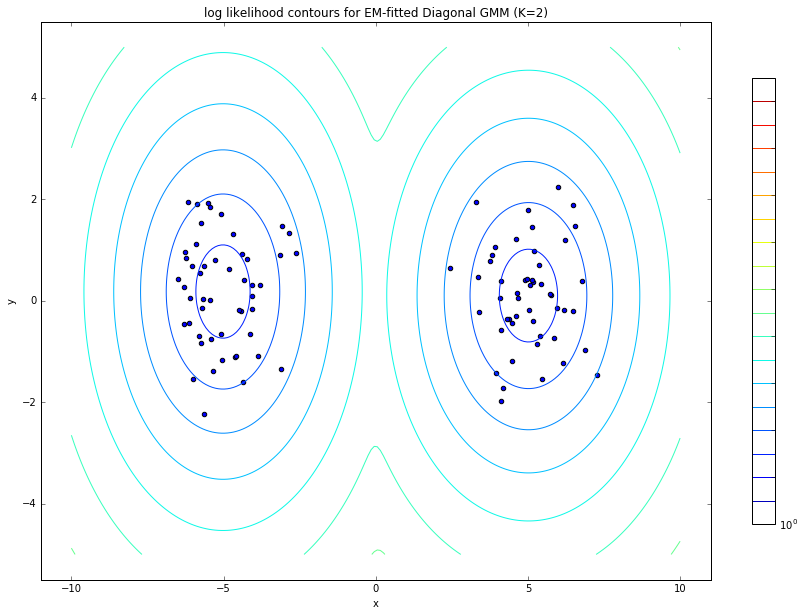

25
[[-3.]
 [ 0.]
 [ 2.]]


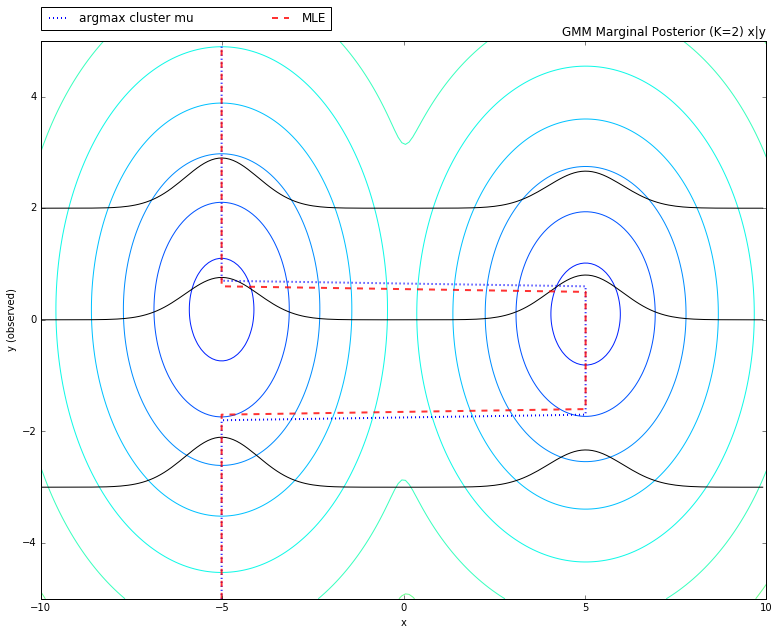

In [6]:
# Check that EM is working on small 2D example

n_samples = 50
np.random.seed(0)

G1 = MVN(np.identity(2), np.array([5, 0]))
G2 = MVN(np.identity(2), np.array([-5, 0]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2])
rx = np.random.choice(range(len(X)), 2, replace=False)

_, m, s, a = fit_em(X, X[rx], 100, EPS)
x = np.linspace(-10.0, 10.0, 200)
y = np.linspace(-5.0, 5.0, 200)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T
with tf.Session() as sess:
    ll = sess.run(-estep(pts, m, s, a)[0])
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
plt.figure(figsize=(15, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.title('log likelihood contours for EM-fitted Diagonal GMM (K=2)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Make this into a nice image.
ys = [-3, 0, 2]
pts = np.arange(-10, 10, 0.1, dtype='float64').reshape(-1, 1)
ys = np.array(ys, dtype='float64').reshape(-1, 1)
# Reverse m, s, a, since we know 'y'
mr, sr = (x[:, ::-1] for x in (m, s))
plotmm, plotsm, plotlgams = marginal_posterior(ys, mr, sr, a)

mle_ys = np.arange(-5, 5, 0.1, dtype='float64').reshape(-1, 1)
mm, sm, lgams = marginal_posterior(mle_ys, mr, sr, a)
ams = np.exp(lgams)
argmax_xs = [argmax_exp(mm, sm, am) for am in lgams]

mle_xs = [None] * len(ams)

def globall(): return glob.glob('data/2-cluster-mle-[0-9]*-[0-9]*.p')

if len(globall()) == 0:
    print('Missing cached posterior MLE predictions, re-generating.')
    with open('data/2-cluster-posterior.p', 'wb') as w:
        pickle.dump((mm, sm, ams), w)
    print(len(mle_ys))
    ! ./xargs-compute-gd-mle.sh data/2-cluster-posterior.p {len(mle_ys)} {nproc // 2} 2-cluster | grep 'Warning'
    print('Done generating')

for f in globall():
    with open(f, 'rb') as r:
        xs = pickle.load(r)
    lo, hi = (int(s[1:]) for s in re.findall(r'-\d+', f))
    mle_xs[lo:hi] = xs
    
print(len(globall()))

print(ys)
plt.figure(figsize=(13, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
with tf.Session() as sess:
    for i, y in enumerate(ys.reshape(-1)):
        lla = sess.run(estep(pts, plotmm, plotsm, np.exp(plotlgams[i]))[0]).reshape(-1)
        plt.plot(pts, np.exp(lla) * 4 + y, ls='-', c='black')

plt.plot(argmax_xs, mle_ys, label='argmax cluster mu', ls =':', c='blue', lw=2)
plt.plot(mle_xs, mle_ys, label='MLE', ls='--', c='red', lw=2, alpha=0.8)
plt.legend(bbox_to_anchor=(0., 1.02, 0.4, 1.02), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('GMM Marginal Posterior (K=2) x|y', loc='right')
plt.xlabel('x')
plt.ylabel('y (observed)')
plt.show()

In [7]:
## Implement custom GMM

tissues_to_cluster = train_tissues[:-1] # note this contains bad tissues 25, 26 still.
X_np = train_df_int[tissues_to_cluster].values.transpose()
N = len(tissues_to_cluster)
K = 10

np.random.seed(2)
rmu = np.random.choice(range(N), K, replace=False)

mu_init = X_np[rmu]

print(mu_init.shape)

lp, m, s, a = fit_em(X_np, mu_init, 100, EPS)
print('mean log likelihood\n{}\nmeans\n{}\ncov\n{}\ncluster priors\n{}'
      .format(lp, m, s, a))

(15, 379551)
mean log likelihood
2206308.1358878566
means
[[ 0.92156863  0.92156863  0.92156863 ...,  0.9512195   0.84        0.974359  ]
 [ 0.8125      0.9347826   0.9583333  ...,  0.94871795  0.6551724
   0.8965517 ]
 [ 0.91457625  0.9516565   0.95543985 ...,  0.92421195  0.92559525
   0.9348371 ]
 ..., 
 [ 0.7222222   0.78531438  0.88515276 ...,  0.70320305  0.7053872
   0.84397322]
 [ 0.93650794  0.95714283  0.8918919  ...,  0.953125    0.7659575
   0.92727274]
 [ 0.6278409   0.7301887   0.89738335 ...,  0.76503759  0.66538462
   0.83854165]]
cov
[[  2.22044605e-15   2.22044605e-15   2.22044605e-15 ...,   2.22044605e-15
    1.77635684e-15   2.44249065e-15]
 [  1.66533454e-15   2.10942375e-15   2.22044605e-15 ...,   2.22044605e-15
    1.16573418e-15   1.99840144e-15]
 [  1.19551706e-03   8.33167328e-05   5.65977859e-05 ...,   3.78304445e-04
    4.34028472e-04   9.04517655e-04]
 ..., 
 [  1.92901265e-02   8.70274780e-04   1.08109506e-03 ...,   8.12493978e-04
    1.27226218e-02   2.37

In [8]:
o = np.ones(len(train_df))
o[train_ix] = 0
o[test_ix] = 0
unobserved_untested_ix = np.where(o)[0]
o = np.zeros(len(train_df))
o[test_ix] = 1
unobserved_tested_ix = np.where(o)[0]

In [9]:
perm = np.hstack((train_ix, unobserved_tested_ix, unobserved_untested_ix))

In [10]:
observed = test_df['filled'][train_ix].values
len(perm), len(train_df)

(379551, 379551)

In [11]:
mm, ms = (x[:, perm] for x in (m, s))
print(len(mm[0]), len(ms[0]), len(a))
print(observed.reshape(1, len(observed)))
print(observed.shape)
mm, sm, ams = marginal_posterior(observed.reshape(1, len(observed)), mm, ms, a)
print(mm.shape, sm.shape, ams.shape)
pred = argmax_exp(mm, sm, ams[0])[:len(unobserved_tested_ix)]
print(pred)
actual = test_df['filled'][unobserved_tested_ix]
print(len(pred), len(actual))
print('rmse', math.sqrt(actual.sub(pred).pow(2).mean())) # rmse of GMM
print('r2', sklearn.metrics.r2_score(actual, pred))
print('mle')
pred2 = gd_mle(mm, sm, np.exp(ams[0]), 5, EPS, warning='gd', verbose=True, minstep=1e-4)
pred2 = pred2.reshape(-1)[:len(unobserved_tested_ix)]
print('rmse', math.sqrt(actual.sub(pred2).pow(2).mean())) # rmse of GMM
print('r2', sklearn.metrics.r2_score(actual, pred2))

379551 379551 15
[[ 0.6888889   0.8518519   0.14666666 ...,  0.877193    0.9259259
   0.41666666]]
(7523,)
(15, 372028) (15, 372028) (1, 15)
[ 0.93101431  0.9450764   0.92257519 ...,  0.92751464  0.89509278
  0.94704886]
368411 368411
rmse 0.07506763606264781
r2 0.802931698404
mle
Running mean 0
   1 of 5 done, NLL = -140038.286118
   2 of 5 done, NLL = 40499887.5439
   3 of 5 done, NLL = 9576359088.89
   4 of 5 done, NLL = 2.12556348063e+12
   5 of 5 done, NLL = 4.29783815325e+14
  Best NLL = 4.29783815325e+14
Running mean 1
   1 of 5 done, NLL = 10921145.5101
   2 of 5 done, NLL = 1094685391.91
   3 of 5 done, NLL = 204777851266.0
   4 of 5 done, NLL = 3.53473766146e+13
   5 of 5 done, NLL = 5.49717945636e+15
  Best NLL = 5.49717945636e+15
Running mean 2
   1 of 5 done, NLL = 1199099.95574
   2 of 5 done, NLL = 74183867.932
   3 of 5 done, NLL = 12110789456.2
   4 of 5 done, NLL = 1.97521798352e+12
   5 of 5 done, NLL = 2.98715923964e+14
  Best NLL = 2.98715923964e+14
Running mean 3
